**Column content in EEG_data.csv**
</br>The first column (A) contains a variable that indicates the video used during the experiment. The videos can be found in Video_details.csv.
</br>The second column (B) contains a variable that indicates who watched the video. More details pertaining to the student can be found in Subject_details.csv.
</br>Columns 3-16 (C - P) contains raw EEG data from the 14 sensors.
</br>Columns 17-86 (Q - CH) contains 5 Brain waves for each sensor.
</br>Column 87 (CI) contains the binary variable that indicates whether the subject understood the lecture or not.

(1 = Understood the lecture | 0 = Did not understand the lecture).

8 students

In [1]:
%%capture
!pip install ssqueezepy #For converting signals to image using wavelet transform
!pip install timm #For existing pre-trained model in pytorch
!pip install pytorch-lightning #For training model

In [2]:
main_path='/content/drive/MyDrive/archive'

In [3]:
#Reading EEG csv
import pandas as pd
import os
df=pd.read_csv(os.path.join(main_path,'EEG_data.csv'))
df.head() #Returns first five rows

,video_id,subject_id,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,...,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma,subject_understood
0,0,0,4210.641113,4179.102539,4287.948730,4235.384766,4207.948730,4165.000000,4135.897461,4170.000000,...,1.583895,0.504567,0.471979,0.138717,1.801014,1.504794,0.258570,0.435745,0.469483,0
1,0,0,4201.025879,4188.717773,4280.128418,4236.922852,4209.615234,4152.436035,4130.128418,4149.487305,...,1.709560,0.606587,0.527616,0.155580,1.859177,1.379617,0.317579,0.468416,0.642560,0
2,0,0,4203.205078,4182.820313,4282.820313,4231.025879,4207.820313,4172.436035,4131.538574,4147.948730,...,1.873591,0.795834,0.565414,0.170816,2.027946,1.283876,0.441925,0.494701,0.798197,0
3,0,0,4186.538574,4168.717773,4266.794922,4229.230957,4202.179688,4155.384766,4128.333496,4151.666504,...,2.110017,1.021118,0.579656,0.180056,2.265952,1.306188,0.616881,0.506062,0.886495,0
4,0,0,4232.436035,4216.922852,4306.922852,4270.769043,4217.436035,4166.538574,4155.897461,4162.820313,...,2.462552,1.230984,0.573620,0.181081,2.461205,1.522420,0.822598,0.498361,0.874455,0


In [4]:
#We need first 16 channels to get raw data 14 channels
cols_remove=df.columns.tolist()[16:-1]
df=df.loc[:,~df.columns.isin(cols_remove)] #assign all rows with the exception of cols to be removed as new df
df.columns = df.columns.str.strip('EEG.')
df.head()

,video_id,subject_id,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,subject_understood
0,0,0,4210.641113,4179.102539,4287.948730,4235.384766,4207.948730,4165.000000,4135.897461,4170.000000,4155.384766,4157.179688,4610.384766,4388.846191,4413.461426,4499.743652,0
1,0,0,4201.025879,4188.717773,4280.128418,4236.922852,4209.615234,4152.436035,4130.128418,4149.487305,4149.487305,4157.820313,4583.717773,4376.666504,4392.820313,4488.461426,0
2,0,0,4203.205078,4182.820313,4282.820313,4231.025879,4207.820313,4172.436035,4131.538574,4147.948730,4131.666504,4131.666504,4574.743652,4377.051270,4390.512695,4483.077148,0
3,0,0,4186.538574,4168.717773,4266.794922,4229.230957,4202.179688,4155.384766,4128.333496,4151.666504,4136.666504,4134.230957,4565.512695,4362.436035,4380.897461,4471.025879,0
4,0,0,4232.436035,4216.922852,4306.922852,4270.769043,4217.436035,4166.538574,4155.897461,4162.820313,4143.461426,4154.487305,4612.436035,4403.333496,4410.641113,4512.179688,0


In [5]:
#Checking the labels of the dataset
df['subject_understood'].unique()

array([0, 1])

In [6]:
#To reshape the data into - subjects, trials, channels and length
#We need to create groups based on subjects (subject might watch more than one video)
groups=df.groupby(['subject_id','video_id'])
grp_keys=list(groups.groups.keys())
print(grp_keys)

[(0, 0), (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (7, 10)]


(0,0) - subject_id:0 & video_id:0

In [7]:
#To save eeg data as mne, we need to remove subject id, video id and label from the data
grpno=grp_keys[0]
grp1=groups.get_group(grpno).drop(columns=['subject_id','video_id'],axis=1)
label=grp1['subject_understood']
subject_id=grpno[0]
grp1=grp1.drop('subject_understood',axis=1)
grp1.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4210.641113,4179.102539,4287.948730,4235.384766,4207.948730,4165.000000,4135.897461,4170.000000,4155.384766,4157.179688,4610.384766,4388.846191,4413.461426,4499.743652
1,4201.025879,4188.717773,4280.128418,4236.922852,4209.615234,4152.436035,4130.128418,4149.487305,4149.487305,4157.820313,4583.717773,4376.666504,4392.820313,4488.461426
2,4203.205078,4182.820313,4282.820313,4231.025879,4207.820313,4172.436035,4131.538574,4147.948730,4131.666504,4131.666504,4574.743652,4377.051270,4390.512695,4483.077148
3,4186.538574,4168.717773,4266.794922,4229.230957,4202.179688,4155.384766,4128.333496,4151.666504,4136.666504,4134.230957,4565.512695,4362.436035,4380.897461,4471.025879
4,4232.436035,4216.922852,4306.922852,4270.769043,4217.436035,4166.538574,4155.897461,4162.820313,4143.461426,4154.487305,4612.436035,4403.333496,4410.641113,4512.179688


In [8]:
%%capture
!pip install mne

In [9]:
#Define function to convert remaining columns to mne
import mne
def convert_to_mne(sub):
  info=mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=128)
  info.set_montage('standard_1020')
  data=mne.io.RawArray(sub.T, info) #Transpose the columns to rows
  data.set_eeg_reference()
  #data.filter(l_freq=1,h_freq=30)
  epochs=mne.make_fixed_length_epochs(data,duration=3,overlap=2)
  return epochs.get_data()

In [10]:
#Testing the function
test=convert_to_mne(grp1)
test.shape

Creating RawArray with float64 data, n_channels=14, n_times=2402
    Range : 0 ... 2401 =      0.000 ...    18.758 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 384 original time points ...
0 bad epochs dropped


(16, 14, 384)

In [11]:
#Create empty folder to hold images of subject trials
!mkdir scaleogram

In [12]:
#Import necessary libraries
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
import mne
from ssqueezepy import cwt
from ssqueezepy.visuals import plot,imshow
import os
import re

In [13]:
#Function that converts signal to image (continuos wavelet transform function)
Wx, scales = cwt(test[0], 'morlet') #14 channels and 384 points

In [14]:
Wx.shape

(14, 230, 384)

To plot, you need to remove the number of channel or change it to either 1 or 3 for grayscale or RGB image

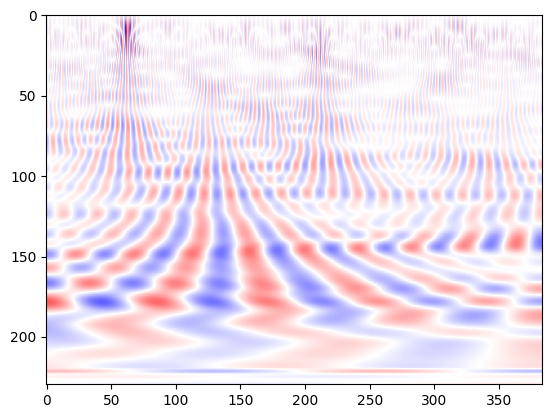

In [15]:
imshow(Wx[0]) #Show scales (frequencies) and time-points for one channel

In [16]:
#Iterate through all groups and creating images for all their trials
%%capture
grpnos, labels,paths=[],[],[]
for i,grpno in enumerate(grp_keys):
  grp=groups.get_group(grpno).drop(['subject_id','video_id'],axis=1)
  label=int(grp['subject_understood'].unique())
  subject_id=grpno[0]
  grp=grp.drop('subject_understood',axis=1)
  data=convert_to_mne(grp) #convert the each grp to trails,channels and length
  for c,x in enumerate(data): #loop through the group's trials
    Wx, scales = cwt(x, 'morlet')
    Wx=np.abs(Wx)
    path=os.path.join('/content/scaleogram',f'subvideo_{grpno}/',)
    os.makedirs(path, exist_ok=True)
    path=path+f'trial_{c}.npy'
    np.save(path,Wx)

    grpnos.append(i)
    labels.append(label)
    paths.append(path)

In [17]:
#Labelling the trial images to have same label and group id
df_scale=pd.DataFrame(zip(paths,labels,grpnos),columns=['path','label','group'])
df_scale.head()

,path,label,group
0,"/content/scaleogram/subvideo_(0, 0)/trial_0.npy",0,0
1,"/content/scaleogram/subvideo_(0, 0)/trial_1.npy",0,0
2,"/content/scaleogram/subvideo_(0, 0)/trial_2.npy",0,0
3,"/content/scaleogram/subvideo_(0, 0)/trial_3.npy",0,0
4,"/content/scaleogram/subvideo_(0, 0)/trial_4.npy",0,0


Dataset wil be grouped by group(subject & video) to avoid the model getting different trails for same group during training and validation.

In [26]:
#Importing libraries for pytorch training
import numpy as np
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.utils import class_weight
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
import torchvision
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import cv2
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchmetrics
import timm
import random

In [19]:
#Reading data from the folder (dataset) apply optional augmentations, and prepare it for use in a PyTorch training loop.
class DataReader(Dataset):
  def __init__(self, dataset, aug=None):
    self.dataset = dataset
    self.aug = aug

  def __getitem__(self, index):
    x=self.dataset.path[index]
    y=self.dataset.label[index]
    x=np.load(x)
    if self.aug:
      if random.uniform(0, 1) > 0.5:
        x=np.flip(x,-1)
      if random.uniform(0, 1) > 0.5:
        x=np.flip(x,-2)
        #if random.uniform(0, 1) > 0.5:
        #  c=np.arrange(14)
        #  np.random.shuffle(c)
        #  x=x[c,:,:]
    x=(x - np.min(x)) / (np.max(x) - np.min(x))
    return x, y

  def __len__(self):
    return len(self.dataset)

dataset: is expected to be a DataFrame or a similar structure containing paths to the data files and their corresponding labels.

In [20]:
#Using the DataReader class and the DataLoader
test_loader=DataLoader(DataReader(df_scale,True), batch_size=8) #Instance of loader with datareader
test_batch=next(iter(test_loader))
test_batch[0].shape, test_batch[1].shape

(torch.Size([8, 14, 230, 384]), torch.Size([8]))

In [21]:
len(test_loader.dataset) #To check the length of the dataset

510

In [24]:
#Importing the pretrained ResNet, Modifying its architecture
import timm
class OurModel(LightningModule):
  def __init__(self,train_split,val_split):
    super(OurModel,self).__init__()
    #Architecture - Lambda resnet

    self.train_split=train_split
    self.val_split=val_split
    #TIMM Model
    model_name='resnet26d'
    self.model=timm.create_model(model_name,pretrained=True)
    self.model.conv1[0]=nn.Conv2d(14, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) #Reseeting the input layer to match our data

    self.fc1=nn.Linear(1000,500) #Last layer of the ResNet has 1000 layer, we need just one layer for our classification
    self.relu=nn.ReLU()
    self.fc2=nn.Linear(500,250)
    self.fc3=nn.Linear(250,1)
    self.drp=nn.Dropout(0.25)

    #parameters
    self.lr=1e-3
    self.batch_size=16
    self.num_workers=2
    self.criterion=nn.BCEWithLogitsLoss()
    self.metrics=torchmetrics.Accuracy(task='binary')

    self.training_step_outputs = []
    self.validation_step_outputs = []
    self.test_step_outputs = []

    self.trainloss, self.valloss=[],[]
    self.trainacc, self.valacc=[],[]

    self.sub_pred=0

  def forward(self,x):
    x=self.model(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.drp(x)
    x=self.fc2(x)
    x=self.relu(x)
    x=self.drp(x)
    x=self.fc3(x)
    return x

  def configure_optimizers(self):
    opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(DataReader(self.train_split,False), batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True, shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    pred=self.forward(image)
    loss=self.criterion(pred.flatten(),label.float()) #calculate loss
    acc=self.metrics(pred.flatten(),label) #calculate accuracy
    self.training_step_outputs.append({"loss": loss, "acc": acc})
    return {'loss':loss,'acc':acc}

  def on_train_epoch_end(self):
    loss=torch.stack([output["loss"] for output in self.training_step_outputs]).mean().detach().cpu().numpy().round(2)
    acc=torch.stack([output["acc"] for output in self.training_step_outputs]).mean().detach().cpu().numpy().round(2)
    self.trainloss.append(loss)
    self.trainacc.append(acc)
    #print('training acc: acc)
    self.log('train_loss', loss)

    # Clear the stored outputs to free memory
    self.training_step_outputs.clear()

  def val_dataloader(self):
    return DataLoader(DataReader(self.val_split,False), batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True, shuffle=True)

  def validation_step(self,batch,batch_idx):
    image,label=batch
    pred=self.forward(image)
    loss=self.criterion(pred.flatten(),label.float()) #calculate loss
    acc=self.metrics(pred.flatten(),label) #calculate accuracy
    self.validation_step_outputs.append({"loss": loss, "acc": acc})
    return {'loss':loss,'acc':acc}

  def on_validation_epoch_end(self):
    loss=torch.stack([output["loss"] for output in self.validation_step_outputs]).mean().detach().cpu().numpy().round(2)
    acc=torch.stack([output["acc"] for output in self.validation_step_outputs]).mean().detach().cpu().numpy().round(2)
    self.trainloss.append(loss)
    self.trainacc.append(acc)
    #print('validation acc', self.current_epoch,acc)
    self.log('val_loss', loss)
    self.log('val_acc', acc)

    # Clear the stored outputs to free memory
    self.validation_step_outputs.clear()

  def test_dataloader(self):
    return DataLoader(DataReader(self.val_split,False), batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True, shuffle=True)

  def test_step(self,batch,batch_idx):
    image,label=batch
    pred=self.forward(image)
    self.test_step_outputs.append({'label':label,'pred':pred})
    return {'label':label,'pred':pred}

  def on_test_epoch_end(self):
    label = torch.cat([output["label"] for output in self.test_step_outputs])
    pred = torch.cat([output["label"] for output in self.test_step_outputs])
    acc = self.metrics(pred.flatten(),label) #calculate accuracy
    pred = pred.detach().cpu().numpy().ravel()
    label = label.detach().cpu().numpy().ravel()
    print('sklearn auc', roc_auc_score(label, pred))
    pred=np.where(pred>0.5,1,0).astype(int)
    print('torch acc', acc)
    print(classification_report(label,pred))
    print('sklearn',accuracy_score(label,pred))

    # Clear the stored outputs to free memory
    self.test_step_outputs.clear()

In [29]:
#Splitting the data data into 5 folds for training and validation
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, StratifiedGroupKFold
gkf=StratifiedGroupKFold(5)
result=[]
valacc=[]
for train_index, val_index in gkf.split(df_scale.path,df_scale.label,groups=df_scale.group):
  train_df=df_scale.iloc[train_index].reset_index(drop=True)
  val_df=df_scale.iloc[val_index].reset_index(drop=True)

  # Check for single class in splits
  if len(train_df['label'].unique()) == 1 or len(val_df['label'].unique()) == 1:
    print("Warning: Single class in train or validation split. Skipping this fold.")
    continue  # Skip this fold and proceed to the next

  lr_monitor=LearningRateMonitor(logging_interval='epoch')
  gpu=-1 if torch.cuda.is_available() else 0
  gpup=16 if torch.cuda.is_available() else 32
  model=OurModel(train_df,val_df)
  trainer = Trainer(max_epochs=20, deterministic=True,
                      accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                      devices=1 if torch.cuda.is_available() else 1,  # Use 1 GPU if available, else None
                      precision=16 if torch.cuda.is_available() else 32,
                      accumulate_grad_batches=2, enable_progress_bar=True,
                      num_sanity_val_steps=0, callbacks=[lr_monitor],)

  trainer.fit(model)
  res=trainer.test(model)
  result.append(res)
  valacc.append(model.valacc)
  trainer.test(model)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 16.0 M | train
1 | fc1       | Linear            | 500 K  | train
2 | relu      | ReLU              | 0      | train
3 | fc2       | Linear            | 125 K  | train
4 | fc3       | Linear

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

sklearn auc 1.0
torch acc tensor(1., device='cuda:0')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        42

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

sklearn 1.0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

sklearn auc 1.0
torch acc tensor(1., device='cuda:0')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        42

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

sklearn 1.0


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 16.0 M | train
1 | fc1       | Linear            | 500 K  | train
2 | relu      | ReLU              | 0      | train
3 | fc2       | Linear            | 125 K  | train
4 | fc3       | Linear

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

sklearn auc 1.0
torch acc tensor(1., device='cuda:0')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        47

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63

sklearn 1.0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


sklearn auc 1.0
torch acc tensor(1., device='cuda:0')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        47

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63

sklearn 1.0


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 16.0 M | train
1 | fc1       | Linear            | 500 K  | train
2 | relu      | ReLU              | 0      | train
3 | fc2       | Linear            | 125 K  | train
4 | fc3       | Linear

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

sklearn auc 1.0
torch acc tensor(1., device='cuda:0')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        44

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

sklearn 1.0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


sklearn auc 1.0
torch acc tensor(1., device='cuda:0')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        44

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

sklearn 1.0


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 16.0 M | train
1 | fc1       | Linear            | 500 K  | train
2 | relu      | ReLU              | 0      | train
3 | fc2       | Linear            | 125 K  | train
4 | fc3       | Linear

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

sklearn auc 1.0
torch acc tensor(1., device='cuda:0')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        51

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

sklearn 1.0


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

sklearn auc 1.0
torch acc tensor(1., device='cuda:0')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        51

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

sklearn 1.0


In [30]:
model.batch_size

16

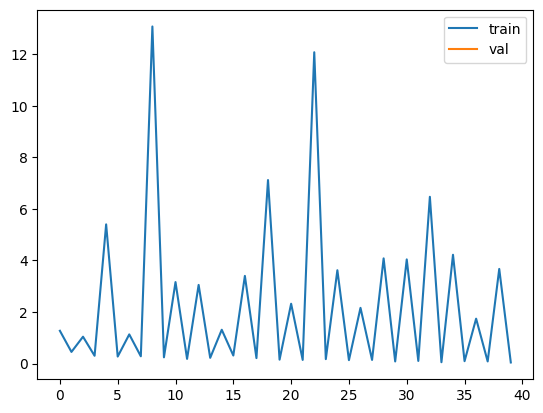

In [31]:
#Visualization of training and validation loss
plt.plot(model.trainloss,label='train')
plt.plot(model.valloss,label='val')
plt.legend()